<a href="https://colab.research.google.com/github/aziztheiri/InsuranceClientSegmentation/blob/main/ProjetML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
import joblib
from flask import Flask, request, jsonify



In [233]:
df = pd.read_csv('users.csv')
df.head()

,Age,Location,Gender,Registration_Date
0,26,Sfax,Female,2016-06-08
1,24,Sfax,Male,2018-05-02
2,22,Sousse,Male,2019-01-25
3,40,Tunis,Male,2020-10-04
4,60,Bizerte,NaN,2018-06-07


In [234]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                3000 non-null   int64 
 1   Location           3000 non-null   object
 2   Gender             2731 non-null   object
 3   Registration_Date  2860 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.9+ KB


In [235]:
print(df.isnull().sum())
print(df.duplicated().sum())


Age                    0
Location               0
Gender               269
Registration_Date    140
dtype: int64
19


In [236]:
print(df.describe(include='all'))


               Age Location Gender Registration_Date
count   3000.00000     3000   2731              2860
unique         NaN        5      2              1843
top            NaN    Gabes   Male        2020-06-10
freq           NaN      632   1386                 6
mean      43.22000      NaN    NaN               NaN
std       18.17835      NaN    NaN               NaN
min       18.00000      NaN    NaN               NaN
25%       27.00000      NaN    NaN               NaN
50%       40.00000      NaN    NaN               NaN
75%       58.00000      NaN    NaN               NaN
max       80.00000      NaN    NaN               NaN


In [237]:
df = df.drop_duplicates()
print("Duplicate Rows After Removal:", df.duplicated().sum())


Duplicate Rows After Removal: 0


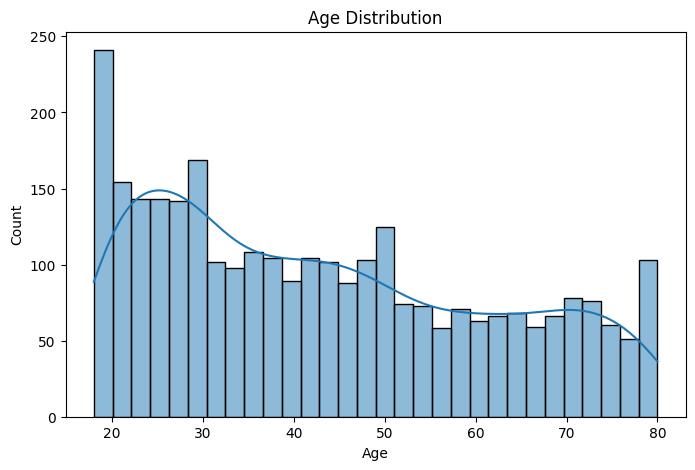

In [238]:
plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

In [239]:
print(df.isnull().sum())


Age                    0
Location               0
Gender               269
Registration_Date    123
dtype: int64


In [240]:

other_count = (df['Gender'] == 'Other').sum()
print(other_count)
df.loc[df['Gender'] == 'Other', 'Gender'] = np.random.choice(['Male', 'Female'], size=other_count, replace=True)

0


In [242]:
print(df['Gender'].value_counts())

Gender
Male      1376
Female    1336
Name: count, dtype: int64


In [243]:
df['Gender'] = df['Gender'].replace({
    'F': 'Female',
    'M': 'Male',
    'Unknown': np.nan,
    'X': np.nan
})
df['Gender'] = df['Gender'].apply(lambda x: np.random.choice(['Male', 'Female']) if pd.isna(x) else x)


In [244]:
print(df['Gender'].value_counts())
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

Gender
Male      1497
Female    1484
Name: count, dtype: int64
Age                    0
Location               0
Gender                 0
Registration_Date    123
dtype: int64
Age                  0
Location             0
Gender               0
Registration_Date    0
dtype: int64


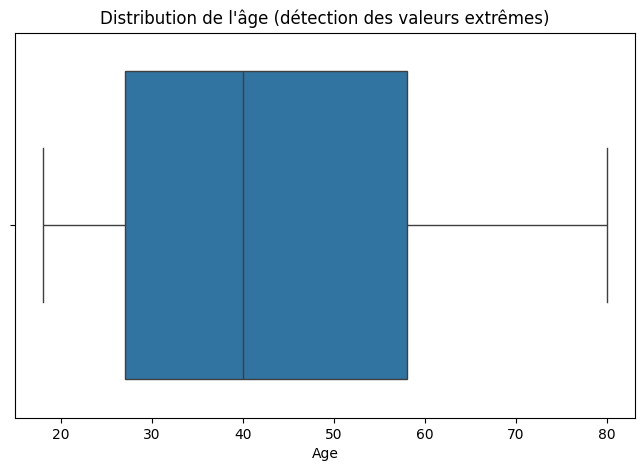

In [245]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Age'])
plt.title("Distribution de l'âge (détection des valeurs extrêmes)")
plt.show()

In [246]:
df = df[(df['Age'] >= 18) & (df['Age'] <= 90)]


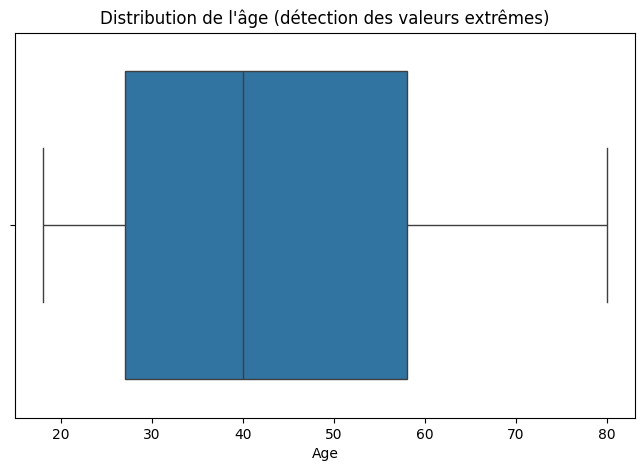

In [247]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Age'])
plt.title("Distribution de l'âge (détection des valeurs extrêmes)")
plt.show()

In [248]:
print(df.shape[0])

2858


In [249]:
#Verifier la forme de la colonne des dates
df['Registration_Date'] = pd.to_datetime(df['Registration_Date'], errors='coerce')
print(df['Registration_Date'].head())


0   2016-06-08
1   2018-05-02
2   2019-01-25
3   2020-10-04
4   2018-06-07
Name: Registration_Date, dtype: datetime64[ns]


In [250]:
df['Registration_Date'] = pd.to_datetime(df['Registration_Date'])
today = datetime.today()
df['Days_since_registration'] = (today - df['Registration_Date']).dt.days

In [252]:
df_clean = df.dropna(subset=['Registration_Date', 'Days_since_registration'])
df.reset_index(drop=True, inplace=True)


In [253]:
gender_encoder = LabelEncoder()
df['Gender'] = gender_encoder.fit_transform(df['Gender'])

location_encoder = LabelEncoder()
df['Location'] = location_encoder.fit_transform(df['Location'])

In [256]:
scaler_age = MinMaxScaler()
scaler = StandardScaler()
df[['Age']] = scaler_age.fit_transform(df[['Age']])

In [257]:
print(df.head())
print(df.info())

        Age  Location  Gender Registration_Date  Days_since_registration
0  0.129032         2       0        2016-06-08                     3189
1  0.096774         2       1        2018-05-02                     2496
2  0.064516         3       1        2019-01-25                     2228
3  0.354839         4       1        2020-10-04                     1610
4  0.677419         0       0        2018-06-07                     2460
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2858 entries, 0 to 2857
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Age                      2858 non-null   float64       
 1   Location                 2858 non-null   int64         
 2   Gender                   2858 non-null   int64         
 3   Registration_Date        2858 non-null   datetime64[ns]
 4   Days_since_registration  2858 non-null   int64         
dtypes: datetime64[ns](1), fl

In [258]:
features = df_clean[['Age', 'Days_since_registration', 'Location', 'Gender']]


In [259]:
features = ['Age', 'Location', 'Gender', 'Days_since_registration']
X = df[features]
scaler_std = StandardScaler()
X_scaled = scaler_std.fit_transform(X)

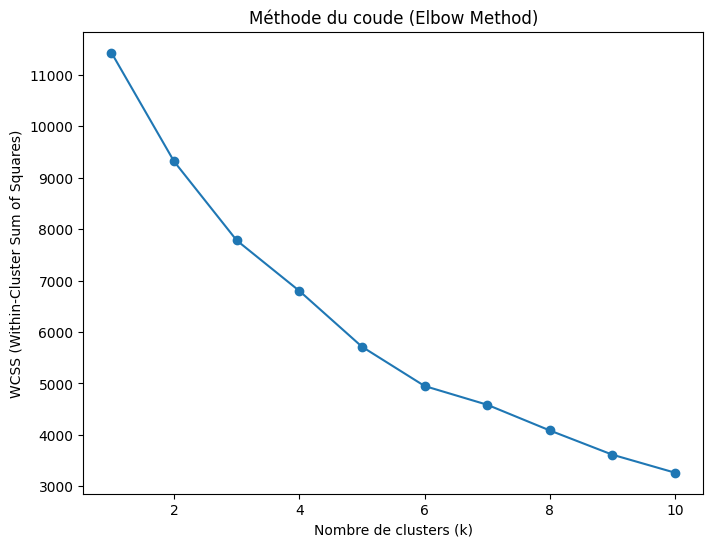

In [260]:


wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Méthode du coude (Elbow Method)')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [261]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [262]:
df['Cluster'] = kmeans.labels_

# Affichage de la répartition des clusters
print("Distribution des clusters :")
print(df['Cluster'].value_counts())

Distribution des clusters :
Cluster
2    682
4    601
1    531
0    525
3    519
Name: count, dtype: int64


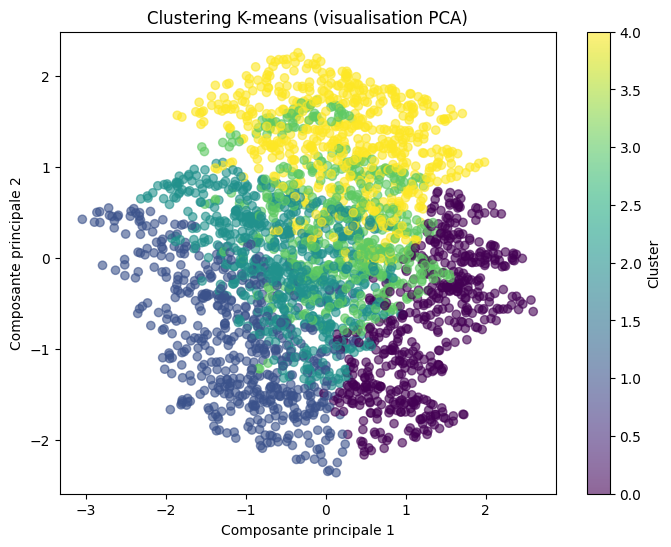

In [263]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.title('Clustering K-means (visualisation PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()

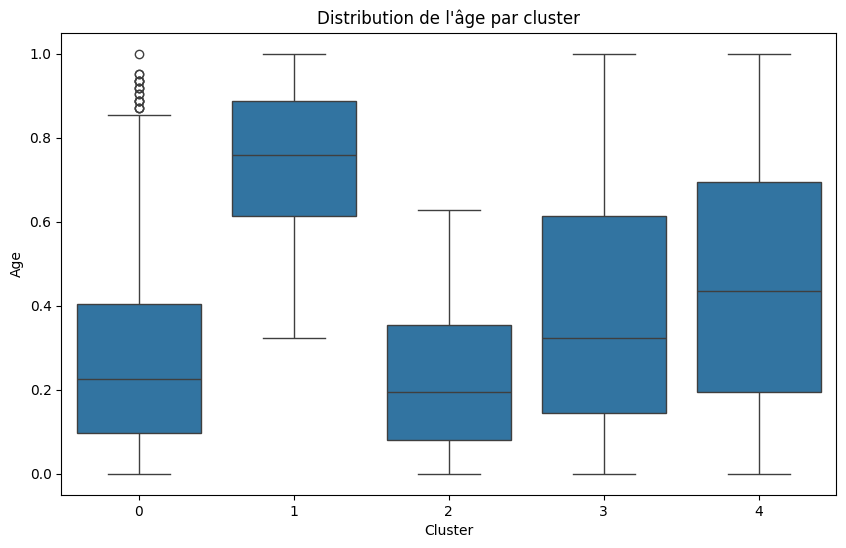

In [264]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title("Distribution de l'âge par cluster")
plt.show()

In [265]:
stats_days = df.groupby('Cluster')['Days_since_registration'].agg(['mean', 'min', 'max', 'median'])
print("Statistiques de Days_since_registration par Cluster :")
print(stats_days)

Statistiques de Days_since_registration par Cluster :
                mean   min   max  median
Cluster                                 
0        3088.415238  1908  3709  3159.0
1        2039.338983   736  3699  1988.0
2        2023.143695   741  3713  1935.5
3        1509.300578   735  2647  1462.0
4        2393.787022   742  3708  2411.0


In [266]:
location_distribution = df.groupby('Cluster')['Location'].value_counts(normalize=True).mul(100)
print("Répartition de Location par Cluster (%):")
print(location_distribution)

Répartition de Location par Cluster (%):
Cluster  Location
0        0           47.238095
         1           36.952381
         2           15.809524
1        1           28.248588
         0           25.047081
         3           17.890772
         2           16.572505
         4           12.241055
2        4           30.791789
         3           30.205279
         2           20.674487
         1           12.756598
         0            5.571848
3        0           32.369942
         1           31.791908
         2           24.470135
         3           11.368015
4        4           49.584027
         3           35.940100
         2           14.475874
Name: proportion, dtype: float64


In [267]:
# Afficher la moyenne, min, max de l'âge par cluster
stats_age = df.groupby('Cluster')['Age'].agg(['mean', 'min', 'max'])
print(stats_age)

             mean       min       max
Cluster                              
0        0.278986  0.000000  1.000000
1        0.739900  0.322581  1.000000
2        0.223678  0.000000  0.629032
3        0.378551  0.000000  1.000000
4        0.454538  0.000000  1.000000


In [268]:
gender_distribution = df.groupby('Cluster')['Gender'].value_counts(normalize=True).mul(100)
print("Répartition de Gender par Cluster (%):")
print(gender_distribution)

Répartition de Gender par Cluster (%):
Cluster  Gender
0        0          56.380952
         1          43.619048
1        1          98.493409
         0           1.506591
2        1         100.000000
3        0          99.421965
         1           0.578035
4        0         100.000000
Name: proportion, dtype: float64


In [269]:
X = df[features]
y = df['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Évaluation du modèle sur l'ensemble de test
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.986013986013986
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       108
           1       1.00      0.99      0.99        91
           2       0.99      1.00      0.99       138
           3       0.97      0.97      0.97       111
           4       0.99      0.99      0.99       124

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572



In [270]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- KNN ---
# Création du modèle KNN (ici, on choisit k=5 par défaut)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Test Accuracy:", accuracy_knn)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Test Accuracy: 0.9842657342657343
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       108
           1       0.96      0.98      0.97        91
           2       0.99      0.98      0.99       138
           3       0.98      0.98      0.98       111
           4       1.00      1.00      1.00       124

    accuracy                           0.98       572
   macro avg       0.98      0.98      0.98       572
weighted avg       0.98      0.98      0.98       572



In [271]:
# --- SVM ---
# Création du modèle SVM avec un noyau RBF
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Test Accuracy:", accuracy_svm)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Test Accuracy: 0.9895104895104895
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       0.98      0.97      0.97        91
           2       0.99      0.99      0.99       138
           3       0.98      0.99      0.99       111
           4       1.00      1.00      1.00       124

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572



In [272]:
# --- Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9982517482517482
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       108
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00       138
           3       0.99      1.00      1.00       111
           4       1.00      1.00      1.00       124

    accuracy                           1.00       572
   macro avg       1.00      1.00      1.00       572
weighted avg       1.00      1.00      1.00       572



In [273]:

# Save the KNN model
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Sauvegarde de l'encodeur pour Gender
joblib.dump(gender_encoder, 'gender_encoder.pkl')

# Sauvegarde de l'encodeur pour Location
joblib.dump(location_encoder, 'location_encoder.pkl')

# Sauvegarde du scaler pour Age (si vous utilisez MinMaxScaler pour Age)
joblib.dump(scaler_age, 'scaler_age.pkl')

# Sauvegarde du StandardScaler utilisé sur l'ensemble des features
joblib.dump(scaler_std, 'scaler_std.pkl')


['scaler_std.pkl']

In [284]:
!pip install flask-ngrok


In [289]:
!ngrok authtoken '2Yj1IQVh4V0mntPyVDBTBW4oGYH_5JJWBTrkkiARCXP8z7HBu'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [291]:
from flask import Flask
from pyngrok import ngrok  # Use pyngrok instead of flask-ngrok

app = Flask(__name__)

# Start ngrok when the app starts
public_url = ngrok.connect(5000)  # 5000 is the default Flask port
print("Public URL:", public_url)

knn_model = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler.pkl')
gender_encoder = joblib.load('gender_encoder.pkl')
location_encoder = joblib.load('location_encoder.pkl')

@app.route('/', methods=['GET'])
def index():
    return "Hello, Flask!"

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)

    # Create a DataFrame from the input data
    df = pd.DataFrame([data])

    # Compute derived feature: Days_since_registration
    df['Registration_Date'] = pd.to_datetime(df['Registration_Date'])
    today = datetime.today()
    df['Days_since_registration'] = (today - df['Registration_Date']).dt.days

    # Encode categorical features
    df['Gender'] = gender_encoder.transform(df['Gender'])
    df['Location'] = location_encoder.transform(df['Location'])

    # Select and scale features
    features = ['Age', 'Location', 'Gender', 'Days_since_registration']
    X = df[features]
    X_scaled = scaler.transform(X)

    # Predict the cluster
    prediction = knn_model.predict(X_scaled)

    return jsonify({'predicted_cluster': int(prediction[0])})
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

Public URL: NgrokTunnel: "https://a70f-34-145-16-117.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [02/Mar/2025 11:51:23] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Mar/2025 11:51:23] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Mar/2025 11:51:46] "POST /predict HTTP/1.1" 200 -
